Your goal is to perform a sensitivity analysis of the parameters in the fly clock model of Goldbeter. The base project is about determining how consistent the sensitivities are across parameter sets. I would love to see extensions that examine which processes have which effects.

## Instructions
<ol>
<li> Use your genetic algorithm to generate 10 excellent parameter sets (i.e. run the algorithm 10 times and use the lowest cost child from each run). You may use parameter sets you found in Project 4 or you may generate new parameter sets.
<li> For each of the parameter sets, analyze the sensitivity of the amplitude and of the period (separately) to each parameter. To analyze the sensitivity of the amplitude, you will need to choose which state variable to focus on, or use the sensitivity of the sum of the amplitudes. Analyzing the amplitude sensitivities of multiple states and comparing the results is an extension.
<li> What are the similarities and differences in sensitivity across parameter sets? Are there parameters that have opposite effects in different parameter sets? 
</ol>
    
## Extensions
<ol>
<li> Analyze additional models
<li> Explore the effects of changing the size of the perturbation used to compute the sensitivities.
<li> Include an analysis of the sensitivity of state dynamics to parametric perturbation.
<li> #1 and #2: Analyze additional state variables (Pauline)
</ol>

## Steps to get you started

### 1. Copy-paste code and/or results from Project 4
You will need the Golbeter's model and get_period at the very least. If you are generating parameter sets in this project, you will also need the GA code and cost function. If you using parameter sets from Project 4, you can just refer to the files that have them (assuming you have .npz file). Save output from .npz file (last project). 

### 2. Write the output functions you want to analyze.
<ol>
<li>Write a function that takes as input the parameters and provides as output the period.
<li>Write a function that takes as input the parameters and provides as output a measurement of the peak-to-trough amplitude. Here is where you can make a decision. You can track the amplitude of one particular state, or sum the amplitudes of all 5 states. In your report, be sure to clearly indicate which you chose.
</ol>

Test them with the published parameters. My output is
<code>
period 23.662222222222223
amplitude of M 2.3759648547322616
amplitude of P0 1.4260629330956047
amplitude of P1 0.7354556871287586
amplitude of P2 0.7550101535148619
amplitude of PN 1.0799752338320783
sum of amplitudes of all states 6.372468862303565</code>

Note: Make sure you run the model for at least 10 days, to eliminate the transient. Then run it again to determine the period or amplitude.

### 3. Write the sensitivity analysis code and test it.

  ## Begin your project here
   
  Complete the project (analyzing the sensitivities) here. If you write extensions, add any support code (e.g. a function to compute the sensitivities to the state dynamics) above. Just concentrate main code for the report here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
from scipy.signal import find_peaks
import scipy.integrate

In [2]:
def gol95_model(t, statevars, params):
    
    M  = statevars[0]; #M
    P0 = statevars[1]; #P0
    P1 = statevars[2]; #P1
    P2 = statevars[3]; #P2
    PN = statevars[4]; #PN
    
    vs = params[0]
    vm = params[1]
    Km = params[2]
    ks = params[3]
    vd = params[4]
    k1 = params[5]
    k2 = params[6]
    KI = params[7]
    Kd = params[8]
    n = params[9]
    K1 = params[10]
    K2 = params[11]
    K3 = params[12]
    K4 = params[13]
    V1 = params[14]
    V2 = params[15]
    V3 = params[16]
    V4 = params[17]
    
    dydt = np.zeros((5,))
    
    dydt[0] = ( vs * ((KI**n)/(KI**n + PN**n)) ) - ( vm * ((M)/(Km + M)) )
    dydt[1] = ks*M - (V1 * ((P0)/(K1+P0))) + (V2 * ((P1)/(K2+P1)))
    dydt[2] = (V1*((P0)/(K1+P0))) - (V2*((P1)/(K2+P1))) - (V3*((P1)/(K3+P1))) + (V4*((P2)/(K4+P2)))
    dydt[3] = (V3*((P1)/(K3+P1))) - (V4*((P2)/(K4+P2))) - (k1*P2) + (k2*PN) - (vd*((P2)/(Kd+P2)))
    dydt[4] = (k1*P2) - (k2*PN)
    
    return dydt

def get_period(arr, t):
    
    peaks, _ = find_peaks(arr)
    time = []
    periods = []
    
    for peak in peaks:
        time.append(t[peak])
    
    for i in range(len(time)-1,0,-1):
        periods.append(time[i] - time[i-1])
        
    return np.mean(periods), np.std(periods)

def gol95_cost( params ):
    
    #Run the simulation with params as the parameters for at least 10 days,
    gol95 = lambda t, y: gol95_model(t, y, params) # how to create params p?
    sol1 = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,480), y0=0.1*np.ones((5,)),  
                                t_eval=np.arange(0,480,0.01))
    
    #Re-run the simulation, beginning with the values from the final time step of the previous simulation.
    sol2 = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,72), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,72,0.01))
    
    #Compute the period  per  and the cycle-to-cycle standard deviation of the period  sdper 
    per, sdper = get_period(sol2.y[0], sol2.t)
    
    #Compute the cost    
    cost = np.sqrt(((per-23.6)/23.6)**2+(sdper/23.6))
    
    return cost

In [3]:
class GASettings:
    
    def __init__(self, numParents = 10, numChildren = 50):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.slope = 15; #for linear ranking selection
        self.tournamentSize = 2;
        self.crossover = 'uniform';
        self.mutation = 0.05; #std of normal distribution computed as mutation*value
        self.eliteCount = 1;
        self.tournamentSize = 2; 
        self.linearRankingRatio = 4;

def select_pool(G, Gcost, settings):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where 
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )

    if settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'tournament':
        for i in range( settings.numParents ):
            idxs = np.random.choice(G.shape[0], (settings.tournamentSize,) )
            # pick the best one, which is smaller index (since costs sorted)
            idx = idxs.min()
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'linearRanking':
        r = settings.linearRankingRatio
        n = settings.numChildren
        pn = 2/n*(1/(1+r))
        p1 = r*pn
        ps = np.zeros((n,))
        for i in range(1,n+1):
            ps[i-1] = pn + (p1-pn)*(n-i)/(n-1)
        cs = ps.cumsum()
        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    elif settings.selection == 'proportional':
        n = settings.numChildren
        sum_costs = sum(Gcost[:n])
        ps = np.zeros((n,))
        for i in range(0,n):
            ps[i] = Gcost[i]/sum_costs      
        cs = ps.cumsum()
        cs = 1 - cs
        cs.sort()
        for i in range( settings.numParents ):
            num = np.random.random() # number between 0 and 1, from uniform distribution
            idx = np.argmax( num < cs )
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]
    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

In [4]:
def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i] 
    so that lb[i] <= params[i] <= ub[i]
    Input:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

In [5]:
def generateChild(cost_fcn, P, lb, ub, settings):
    """
    Generate a viable child (i.e one whos cost function is finite)
    and return it and its cost function.
    If 1000 tries fails to yield a parent, then an infinite cost
    is returned.
    Input Parameters:
        cost_fcn: handle to the cost function (which should take a candidate as input)
        P: parents (lam x NP ndarray of parameter values)
        lb: lower bounds for parameters (array of length NP)
        ub: upper bounds for parameters (array of length NP)
        settings: a GASettings object
    Returns:
        (params, cost)
        where params is the same shape as the lower bounds
        and cost is the cost for that set of parameters
    """
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range(1000):
        # Choose two parenst from the breeding pool.
        P1idx = np.random.choice(P.shape[0]);
        P1  = P[P1idx,:];
        P2idx = np.random.choice(P.shape[0]);
        P2  = P[P2idx,:];
        for j in range(lb.size):
            # uniform cross-over
            if np.random.random() < 0.5:
                params[j] = P1[j];
            else:
                params[j] = P2[j];
        # Mutate optimization variables
        params = np.multiply( 1+np.random.randn(params.size)*settings.mutation, params);
        # Make sure the mutation hasn't moved us out of bounds
        params = np.maximum(params,lb);
        params = np.minimum(params,ub);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return ( params, cost );
    return (np.zeros((lb.size)), np.inf)

In [6]:
def GA(cost_fcn, lb, ub, settings):
    """ Run the algorithm described in the notes to find a low-cost
        population of parameter sets.
        Input:
            cost_fcn: handle to cost function (should take a paramer set as input)
            lb: lower bounds for parameters (numpy array of length NP)
            ub: lower bounds for parameters (numpy array of length NP)
            settings: GASettings object
        Returns
            (params, cost, all_params, all_costs)
            where 
            params is a 1xNP vector with the best parameter set found
            cost is a scalar with the cost of the best parameter set
            all_params is a list with a (settings.numChildren x NP) ndarray of parameters for each generation
            all_costs is a list with an NP-length array of costs for each generation
    """

    mu = settings.numParents;
    lam = settings.numChildren;
    numGenerations = settings.numGenerations;

    # Create initial population
    G = np.zeros( (lam,lb.size) );
    Gcost = np.zeros( (lam,) );
    for i in range(lam):
        (G[i,:], Gcost[i]) = generateIndividual(cost_fcn, lb, ub);
    # sort them by cost
    idx   = np.argsort(Gcost);
    Gcost = Gcost[idx]
    G     = G[idx,:];
    all_params = [G]
    all_costs = [Gcost]
    mean_gen_cost = []
    median_gen_cost=[]

    for g in range(numGenerations):
        # Promote any elites
        elites = G[:settings.eliteCount,:]
        eliteCosts = Gcost[:settings.eliteCount]
        # select breeding pool
        (P, Pcost) = select_pool( G, Gcost, settings )
        # Generate the children for generation g
        G = np.zeros((lam, lb.size));
        Gcost = np.zeros((lam,));
        G[:settings.eliteCount,:] = elites
        Gcost[:settings.eliteCount] = eliteCosts
        for i in range(settings.eliteCount,lam):
           (G[i,:], Gcost[i]) = generateChild(cost_fcn, P, lb, ub, settings); 
        # sort the children of this generation
        idx   = np.argsort(Gcost);
        Gcost = Gcost[idx]
        G     = G[idx,:];
        print('Best of generation ', g+1, ' has cost ', Gcost[0]);
        all_params.append(G)
        all_costs.append(Gcost)
        mean_gen_cost.append(np.mean(Gcost))
        median_gen_cost.append(np.median(Gcost)) # EXTENSION - Pauline

    params = G[0,:];
    cost   = Gcost[0];
    return (params, cost, all_params, all_costs, mean_gen_cost, median_gen_cost)

In [7]:
#Takes as input the parameters and provides as output the period.
def simulate_gol95( params, t0=0, tStop=240, dt=0.1 ):
    """ Simulate the Golbeter's model with the given parameters
        at the given time steps and return the solution record. """
    yinit = np.ones((5,));
    gol95 = lambda t, statevars: gol95_model(t, statevars, params)
    sol = scipy.integrate.solve_ivp(fun=gol95, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1), args=[params] )

    gol95_2 = lambda t, statevars: gol95_model(t, statevars, params)
    sol = scipy.integrate.solve_ivp(fun=gol95_2, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), args=[params], rtol=1e-8 )

    return sol

def gol95_period( params ):
    """ Simulate the Golbeter's model with the given parameters
        and return the period (a scalar) """
    sol = simulate_gol95( params )
    (per,sdper) = get_period(sol.t, sol.y[0,:])
    return per

def gol95_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all five states
        If which_state  == -1, then return the sum of all 5.
        Otherwise, which_state should be 0 (for M), 1 (for P), or 2 (for I)
    """
    sol = simulate_gol95( params )
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()

In [8]:
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel

In [9]:
#Sets the lower and upper bounds.
lb = np.zeros((18,));
ub = np.zeros((18,));
lb[0] = 0;   ub[0] = 1;# vs = 0.76;
lb[1] = 0;   ub[1] = 1;# vm = 0.65;
lb[2] = .1;  ub[2] = 1;# Km = 0.5;
lb[3] = 0;   ub[3] = 1;# ks = 0.38;
lb[4] = 0;   ub[4] = 1;# vd = 0.95;
lb[5] = 0;   ub[5] = 2;# k1 = 1.9;
lb[6] = 0;   ub[6] = 2;# k2 = 1.3;
lb[7] = 1;   ub[7] = 1;# KI = 1;
lb[8] = 0.1; ub[8] = 1;# Kd = 0.2;
lb[9] = 4;  ub[9] = 4;# n = 4;
lb[10] = 0.5;  ub[10] = 2.5;# K1 = 2;
lb[11] = 0.5;  ub[11] = 2.5;# K2 = 2;
lb[12] = 0.5;  ub[12] = 2.5;# K3 = 2;
lb[13] = 0.5;  ub[13] = 2.5;# K4 = 2;
lb[14] = 0;  ub[14] = 5;# V1 = 3.2;
lb[15] = 0;  ub[15] = 5;# V2 = 1.58;
lb[16] = 0;  ub[16] = 5;# V3 = 5;
lb[17] = 0;  ub[17] = 5;# V4 = 2.5;

In [10]:
#Runs the GA for tournament selection operator with size 5.
#Runs the algorithm 10 times and saves the results in .npz files.
settings = GASettings(numParents=10, numChildren=50)
settings.numGenerations = 6;
settings.eliteCount = 1;
settings.selection = 'tournament';
settings.tournamentSize = 5;

for runNum in range(1,11):
    fn = "Gol95_tournament%d_run%d.npz" % (settings.tournamentSize,runNum)
    if os.path.isfile(fn):
        continue
    # the lowest cost individual from the 5th generation are saved in params
    (params, cost, all_params, all_costs, mean_gen_cost, median_gen_cost) = GA(gol95_cost, lb, ub, settings);

C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Best of generation  1  has cost  0.14152542372881355
Best of generation  2  has cost  0.04533898305084864
Best of generation  3  has cost  0.0016949152542372519
Best of generation  4  has cost  0.0016949152542372519
Best of generation  5  has cost  0.0016949152542372519
Best of generation  6  has cost  1.5427981333897782e-08
Best of generation  1  has cost  0.04903230838083946
Best of generation  2  has cost  0.03516949152542365
Best of generation  3  has cost  0.008050847457632722
Best of generation  4  has cost  0.006779661016960261
Best of generation  5  has cost  0.005508474576284808
Best of generation  6  has cost  0.005508474576284808
Best of generation  1  has cost  0.07754237288135656
Best of generation  2  has cost  0.052279018104631994
Best of generation  3  has cost  0.017635723535305396
Best of generation  4  has cost  0.010593220338990156
Best of generation  5  has cost  0.010593220338990156
Best of generation  6  has cost  0.010593220338990156
Best of generation  1  has c

In [ ]:
#For each of the parameter sets, analyze the sensitivity of the amplitude and of the period (separately) to each parameter. 
#To analyze the sensitivity of the amplitude, you will need to choose which state variable to focus on, or 
#use the sensitivity of the sum of the amplitudes.
#Analyzing the amplitude sensitivities of multiple states and comparing the results is an extension

#Plots the costs for each generation of each simulation.
tournamentSize = 5
plt.figure(figsize=(8,8))

params = []

#Reads in the data from the simulations.
for runNum in range(1,6):
    fn = "Gol95_tournament%d_run%d.npz" %(tournamentSize,runNum)
    f = np.load( fn, allow_pickle=True )
    #all_params = f['all_params']
    params.append(f['params'])

#     #Plots the subplot with log-scale to have a clearer sense of what is happening.
#     plt.subplot(5, 2, (runNum-1)*2+2)
#     for i in range(len(all_costs)):
#         plt.semilogy( np.arange(all_costs[i].size), all_costs[i], '-')
#     plt.title("Log Cost of Population with Tournament")
#     plt.xlabel('Individual')   

# plt.tight_layout()
# plt.legend(legs, loc="lower center", bbox_to_anchor=(1.5, -0.15), ncol=1)

C:\Users\Pauline Nguyen\Anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:32: UserWarning: The following arguments have no effect for a chosen solver: `args`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


period nan
amplitude of M 2.3759586739590497
amplitude of P0 1.4260569748128926
amplitude of P1 0.7354529116190385
amplitude of P2 0.7550090990407692
amplitude of PN 1.0799710705548413
amplitude of M+P0+P1+P2+PN 6.3724487299865915


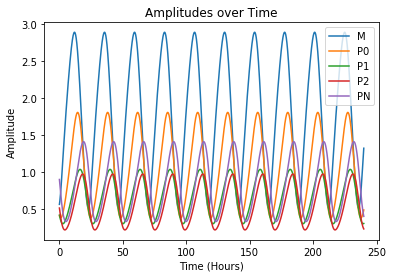

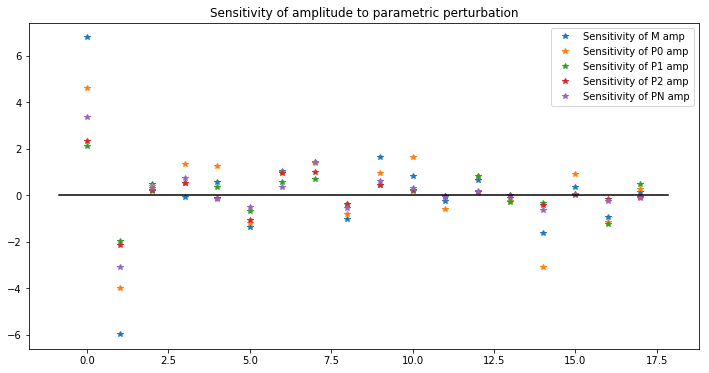

In [11]:
# Compute the period and amplitude of the Goodwin oscillator with published parameters

vs = 0.76
vm = 0.65
Km = 0.5
ks = 0.38
vd = 0.95
k1 = 1.9
k2 = 1.3
KI = 1
Kd = 0.2
n = 4
K1 = 2
K2 = 2
K3 = 2
K4 = 2
V1 = 3.2
V2 = 1.58
V3 = 5
V4 = 2.5    

pub_params = [vs, vm, Km, ks, vd, k1, k2, KI, Kd, n, K1, K2, K3, K4, V1, V2, V3, V4]
param_names = ['vs','vm','Km','ks','vd','k1','k2','KI', 'Kd', 'n', 'K1', 'K2', 'K3', 'K4', 'V1', 'V2', 'V3', 'V4']

per = gol95_period( pub_params )
print("period", per)
amp1 = gol95_amplitude( pub_params, which_state = 0 )
print( "amplitude of M", amp1)
amp2 = gol95_amplitude( pub_params, which_state = 1 )
print( "amplitude of P0", amp2)
amp3 = gol95_amplitude( pub_params, which_state = 2 )
print( "amplitude of P1", amp3)
amp4 = gol95_amplitude( pub_params, which_state = 3 )
print( "amplitude of P2", amp4)
amp5 = gol95_amplitude( pub_params, which_state = 4 )
print( "amplitude of PN", amp5)
ampTot = gol95_amplitude( pub_params, which_state = -1 )
print( "amplitude of M+P0+P1+P2+PN", ampTot)

sol = simulate_gol95( pub_params, tStop=10*24)

plt.plot( sol.t, sol.y.T );
plt.legend( ["M","P0","P1", "P2", "PN"]);
plt.xlabel("Time (Hours)")
plt.ylabel("Amplitude")
plt.title("Amplitudes over Time")

# Compute sensitivity of all 5 states
state_names = ["M","P0","P1", "P2", "PN"]
legs = []
plt.figure(figsize=(12,6))
for i in range(len(state_names)):
    Srel = sensitivity( lambda p: gol95_amplitude( p, which_state = i), np.array(pub_params), 0.05 )
    plt.plot( np.arange(len(pub_params)), Srel, '*')
    #plt.xticks( ticks=np.arange(len(param_names)), labels=param_names);
    plt.title( "Sensitivity of amplitude to parametric perturbation" );
    legs.append( "Sensitivity of %s amp" % state_names[i])

plt.plot( plt.xlim(), [0, 0], 'k');
plt.legend( legs );

# Mention that we are doing all five states in report (requirement). 



<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*